In [1]:
from os import listdir
from os.path import isfile, join

def getFilenames(path):
    return [path+f for f in listdir(path) if isfile(join(path, f))]

# Get argus data
arguspath = "data/argus/csv/"
argusCSVs = getFilenames(arguspath)

# Get pcap data
pcappath = "data/csv/"
pcapCSVs = getFilenames(pcappath)

# Get server logs
logpath = "data/experiment0-0.0001/shadow.data/hosts/mymarkovservice0/"
logs = getFilenames(logpath)

# Combine all locations
data = argusCSVs + pcapCSVs + logs

import pandas as pd
df = pd.read_csv (pcapCSVs[0])
len(logs)

8

In [2]:
import json 

class PrivacyScope:

    def __init__(self, filenames, name):
        self.name = name
        self.filenames = filenames
        self.time_format = '%b %d, %Y %X.%f'
        self.time_cut_tail = -7
        self.time_col = 'frame.time'
        self.filter_func = lambda df, args: df
        self.df = None
        self.ip_search_enabled = False
        self.cache_search_enabled = False
        self.cache_timing = pd.Timedelta("300 seconds")
    
    def __str__(self):
        return "PrivacyScope(" + self.name + ")"
    
    def set_offset(self, timeoffset):
        self.timeoffset = timeoffset
        self.as_df()
        self.df[self.time_col] +=timeoffset
    
    def process_log(self, fn, sep='\t', cols=["time", "format", "data"]):
        df = pd.read_csv(fn,sep=sep, names=cols)
        m = pd.json_normalize(df["data"].apply(json.loads))
        df.drop(["data"], axis=1, inplace=True)
        df = pd.concat([df, m], axis = 1, sort=False)
        return df

    def as_df(self, filenames=None):
        if self.df is not None:
            return self.df
        if filenames == None:
            filenames = self.filenames
        df = pd.DataFrame()
        for f in filenames:
            if f.endswith(".csv"):
                ddf = pd.read_csv (f)
            elif f.endswith("stdout"):
                ddf = self.process_log(f)
            df = pd.concat([df, ddf])
        self.df = df
        self.format_time_col()
        return self.df
        
    def get_ts(self):
        return None
    
    def format_time_col(self):
        if self.time_format == 'epoch':
            self.df[self.time_col] = self.df[self.time_col].apply(lambda x: datetime.fromtimestamp(float(x)))
        else:
            self.df[self.time_col] = self.df[self.time_col].apply(lambda x: datetime.strptime(x[:self.time_cut_tail], self.time_format))
        # print(self.df)
        # self.df.set_index(self.time_col, inplace=True)
        return self.df

    def pcap_only(self):
        r = re.compile(".*data/csv.*")
        return list(filter(r.match, self.filenames))
    
    def pcap_df(self):
        return self.as_df(filenames=self.pcap_only())
    
    def set_filter(self, filter_func):
        self.filter_func = filter_func
        
    def run_filter(self, args):
        return self.filter_func(self.as_df(), args)
    
    def filterByIP(self, ip, run_filter=True, args=None):
        df = self.as_df()
        if run_filter:
            df = self.run_filter(args)
        return df[((df['ip.dst'] == ip) | \
                                   (df['ip.src'] == ip))]

    def filterByCache(self, ip, cache_data, run_filter=True, args=None):
        df = self.as_df()
        if run_filter:
            df = self.run_filter(args)

        df_times = df[self.time_col].tolist()
        input_times = cache_data[self.time_col].tolist()
        keepers = [False] * len(df_times)
        idx = 0
        stop = len(input_times)
        for i in range(0, len(df_times)):
            if idx >= stop:
                break
            diff = input_times[idx] - df_times[i]
            if diff <= pd.Timedelta(0):
                idx += 1
            elif diff < self.cache_timing:
                keepers[i] = True
        
        return df[keepers]
    
    def search(self, ip=None, cache_data=None):
        matches = []
        if self.ip_search_enabled and ip is not None:
            matches += [self.filterByIP(ip)]
        if self.cache_search_enabled and cache_data is not None:
            matches += [self.filterByCache(ip, cache_data)]
        return matches

In [3]:
# Basic Scopes
import re

# Get all clients and ISP dns scope
r = re.compile(".*isp.csv|.*group[0-9]*user[0-9]*-(?!127\.0\.0\.1)[0-9]*.[0-9]*.[0-9]*.[0-9]*..csv")
ISP_scope = PrivacyScope(list(filter(r.match, data)), "ISP")


# Access to public resolver scope
r = re.compile(".*isp.*.csv")
Access_resolver = PrivacyScope(list(filter(r.match, data)), "Access_resolver")

r = re.compile("(.*tld).*.csv")
tld = PrivacyScope(list(filter(r.match, data)), "TLD")

r = re.compile("(.*root).*.csv")
root = PrivacyScope(list(filter(r.match, data)), "root")

r = re.compile("(.*sld).*.csv")
sld = PrivacyScope(list(filter(r.match, data)), "SLD")

# Access Tor Scope
r = re.compile(".*group[0-9]*user[0-9]*-(?!127\.0\.0\.1)[0-9]*.[0-9]*.[0-9]*.[0-9]*..csv")
Access_tor = PrivacyScope(list(filter(r.match, data)), "Access_tor")

# Server Public Scope
r = re.compile(".*myMarkovServer0*-(?!127\.0\.0\.1)[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*.csv")
Server_scope = PrivacyScope(list(filter(r.match, data)), "Server_of_interest")

# tor Exit scope
r = re.compile(".*exit.*")
Tor_exit_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_exit")

# tor Guard scope
r = re.compile(".*guard.*")
Tor_guard_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_guard")

# tor Relay scope
r = re.compile(".*relay.*")
Tor_relay_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_relay")

# tor Middle scope
r = re.compile(".*middle.*")
Tor_middle_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_middle")

# tor 4uthority scope
r = re.compile(".*4uthority.*")
Tor_4uthority_Scope = PrivacyScope(list(filter(r.match, data)), "Tor_4uthority")

# resolver scope
r = re.compile(".*resolver.*")
resolver = PrivacyScope(list(filter(r.match, data)), "resolver")

In [4]:
from datetime import datetime

def df_to_ts(df, time_col='frame.time'):
    df['count'] = 1
    tmp = df.set_index(time_col).infer_objects()
    tmp = tmp.resample('3S').sum(numeric_only=True).infer_objects()
    return tmp.reset_index()

# get start time for GNS3
GNS3_data = pd.concat([Access_resolver.pcap_df(), sld.pcap_df(), tld.pcap_df(), root.pcap_df()])
GNS3_starttime = GNS3_data.head(1)['frame.time'].tolist()[0]
Shadow_starttime = datetime.strptime('Dec 31, 1999 19:26:00', '%b %d, %Y %X')
Shadow_offset = GNS3_starttime - Shadow_starttime
Shadow_offset

Timedelta('8521 days 03:51:53.364576')

In [5]:
# service log scope
r = re.compile(".*mymarkovservice.*py.*stdout")
chatlog = PrivacyScope(list(filter(r.match, data)), "chatlogs")
chatlog.time_col = "time"
chatlog.time_cut_tail = 0
chatlog.time_format = 'epoch'
chatlog.set_offset(Shadow_offset)

In [6]:
chatlog.as_df()

,time,format,username,text
0,2023-04-30 23:21:53.514576,application/json,/tordata/config/group_0_user_4,"Judging by his Horizon score, I'm guessing he ..."
1,2023-04-30 23:21:54.514576,application/json,/tordata/config/group_0_user_2,It's this line that tells me everything I need...
2,2023-04-30 23:21:54.815576,application/json,/tordata/config/group_0_user_2,"While I disagree with the weapon complaint, I ..."
3,2023-04-30 23:21:55.015576,application/json,/tordata/config/group_0_user_2,Yep. Weapons breaking isn't a big deal at all....
4,2023-04-30 23:21:55.215576,application/json,/tordata/config/group_0_user_2,I felt the same way. I saw a bunch of 10/10 re...
...,...,...,...,...
4284,2023-05-01 01:21:31.514577,application/json,/tordata/config/group_4_user_0,"Yes, that's the point. They give you the freed..."
4285,2023-05-01 01:21:32.514576,application/json,/tordata/config/group_4_user_0,"The freedom to choose comes in regards to ""I d..."
4286,2023-05-01 01:21:32.714576,application/json,/tordata/config/group_4_user_0,I also apologize for my lazy answer previously...
4287,2023-05-01 01:21:33.514577,application/json,/tordata/config/group_4_user_0,"Hm, I guess I'd rather have all the possibilit..."


In [7]:
window = pd.Timedelta("300 seconds") # cache size but maybe smaller 

# detect and remove solo quries
# these can easily be handled on their own as only 1 device is accessing the network at that moment
def detect_solo(df_list):
    new_df = df_list[df_list['ip.src'].ne(df_list['ip.src'].shift())]
    new_df['diff'] = new_df['frame.time'].diff()
    new_df = new_df[new_df['diff'] > window]
    solo_ips = new_df['ip.src'].unique()
    return solo_ips

def handle_solo(solo):
    print("IPs that must trigger a cache miss: " + str(solo))
    
def solo_pipeline(df_list):
    fil = df_list[['ip.src', 'frame.time']]
    solo = detect_solo(fil)
    handle_solo(solo)
    return solo

In [8]:
def combineScopes(dfs):
    if len(dfs) < 1:
        return dfs
    return pd.concat(dfs)

def scopesToTS(dfs):
    output = []
    for df in dfs:
        if len(df) < 2:
            continue
        output += scopeToTS(df)
    return output

def scopeToTS(df):
    return df_to_ts(df.copy()).set_index('frame.time')

def scope_label(df, scope_name):
    for col in df.columns:
        df[col + "_" + scope_name] = df[col]
    df["scope_name"]=scope_name
    return df

In [9]:
# Setup filters for different scopes
evil_domain = 'evil.dne'
DNS_PROTO = 17.0

dns_filter = lambda df, ip: df[(df['dns.qry.name'] == evil_domain )
                                            | (df['dns.qry.name'] == "") & (df['ip.proto'] == DNS_PROTO)]
resolver.set_filter(dns_filter)
root.set_filter(dns_filter)
tld.set_filter(dns_filter)
sld.set_filter(dns_filter)


resolver.ip_search_enabled = True
resolver.cache_search_enabled = False

root.ip_search_enabled = True
root.cache_search_enabled = True

sld.ip_search_enabled = True
sld.cache_search_enabled = True

tld.ip_search_enabled = True
tld.cache_search_enabled = True

In [10]:
# Cluster DNS
## Create ts for each IP
resolv_df = resolver.pcap_df()
resolv_df_filtered = resolv_df[resolv_df['ip.proto'] == DNS_PROTO]
IPs = resolv_df_filtered['ip.src'].unique()
flows_ip = {}
flows_ts_ip_scoped = {}
flows_ts_ip_total = {}
infra_ip = ['172.20.0.11', '172.20.0.12', '192.168.150.10', '172.20.0.10']
first_pass = resolv_df_filtered[((~resolv_df_filtered['ip.src'].isin(infra_ip)))  \
                                         & (resolv_df_filtered['dns.qry.name'] == evil_domain)]
solo = solo_pipeline(first_pass)

# Add all scope data to IPs found in resolver address space
# This should be a valid topo sorted list of the scopes (it will be proccessed in order)
scopes = [resolver, root, tld, sld]
cache_window = window # see above 
print("scopes: " + str(scopes))
print("cache window: " + str(cache_window))

for ip in IPs:
    # Don't add known infra IPs or users that can are solo communicaters
    if ip in infra_ip or ip in solo:
        continue
    flows_ip[ip] = pd.DataFrame()
    flows_ts_ip_scoped[ip] = pd.DataFrame()
    flows_ts_ip_total[ip] = pd.DataFrame()
    for scope in scopes:
        # Find matches
        matches = scope.search(ip, flows_ip[ip])
        
        # Update df for ip
        combined_scope = combineScopes(matches)
        combined_scope = scope_label(combined_scope, scope.name)
        combined_scope["scope_name"]=scope.name
        flows_ip[ip] =combineScopes([flows_ip[ip],combined_scope])
        
        # update ts for ip
        new_ts_matches = scopeToTS(combined_scope)
        if len(new_ts_matches) == 0:
            continue
        new_ts_matches["scope_name"]=scope.name
        flows_ts_ip_scoped[ip] = combineScopes([flows_ts_ip_scoped[ip], new_ts_matches])
    if len(flows_ip[ip]) > 0:
        flows_ts_ip_total[ip] = scopeToTS(flows_ip[ip])
        
        # order df by time
        flows_ip[ip] = flows_ip[ip].set_index('frame.time')
        
        # sort combined df by timestamp
        flows_ip[ip].sort_index(inplace=True)
        flows_ts_ip_scoped[ip].sort_index(inplace=True)
        flows_ts_ip_total[ip].sort_index(inplace=True)
        
        # Preserve time col to be used for automated feautre engineering
        flows_ip[ip]['frame.time'] = flows_ip[ip].index
        flows_ts_ip_total[ip]['frame.time'] = flows_ts_ip_total[ip].index
        
        # label scope col as category
        flows_ip[ip]["scope_name"] = flows_ip[ip]["scope_name"].astype('category')
        flows_ts_ip_scoped[ip]["scope_name"] = flows_ts_ip_scoped[ip]["scope_name"].astype('category')
        
        # remove nans with 0
        flows_ip[ip].fillna(0, inplace=True)
        flows_ts_ip_scoped[ip].fillna(0, inplace=True)
        flows_ts_ip_total[ip].fillna(0, inplace=True)

/tmp/ipykernel_354662/1199005426.py:40: DtypeWarning: Columns (2,3,45) have mixed types. Specify dtype option on import or set low_memory=False.
  ddf = pd.read_csv (f)
/tmp/ipykernel_354662/1875783797.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['diff'] = new_df['frame.time'].diff()


IPs that must trigger a cache miss: ['102.0.0.16' '102.0.0.13' '102.0.0.30']
scopes: [<__main__.PrivacyScope object at 0x7ff7fb9704f0>, <__main__.PrivacyScope object at 0x7ff7fb972920>, <__main__.PrivacyScope object at 0x7ff7fb972410>, <__main__.PrivacyScope object at 0x7ff7fb971000>]
cache window: 0 days 00:05:00


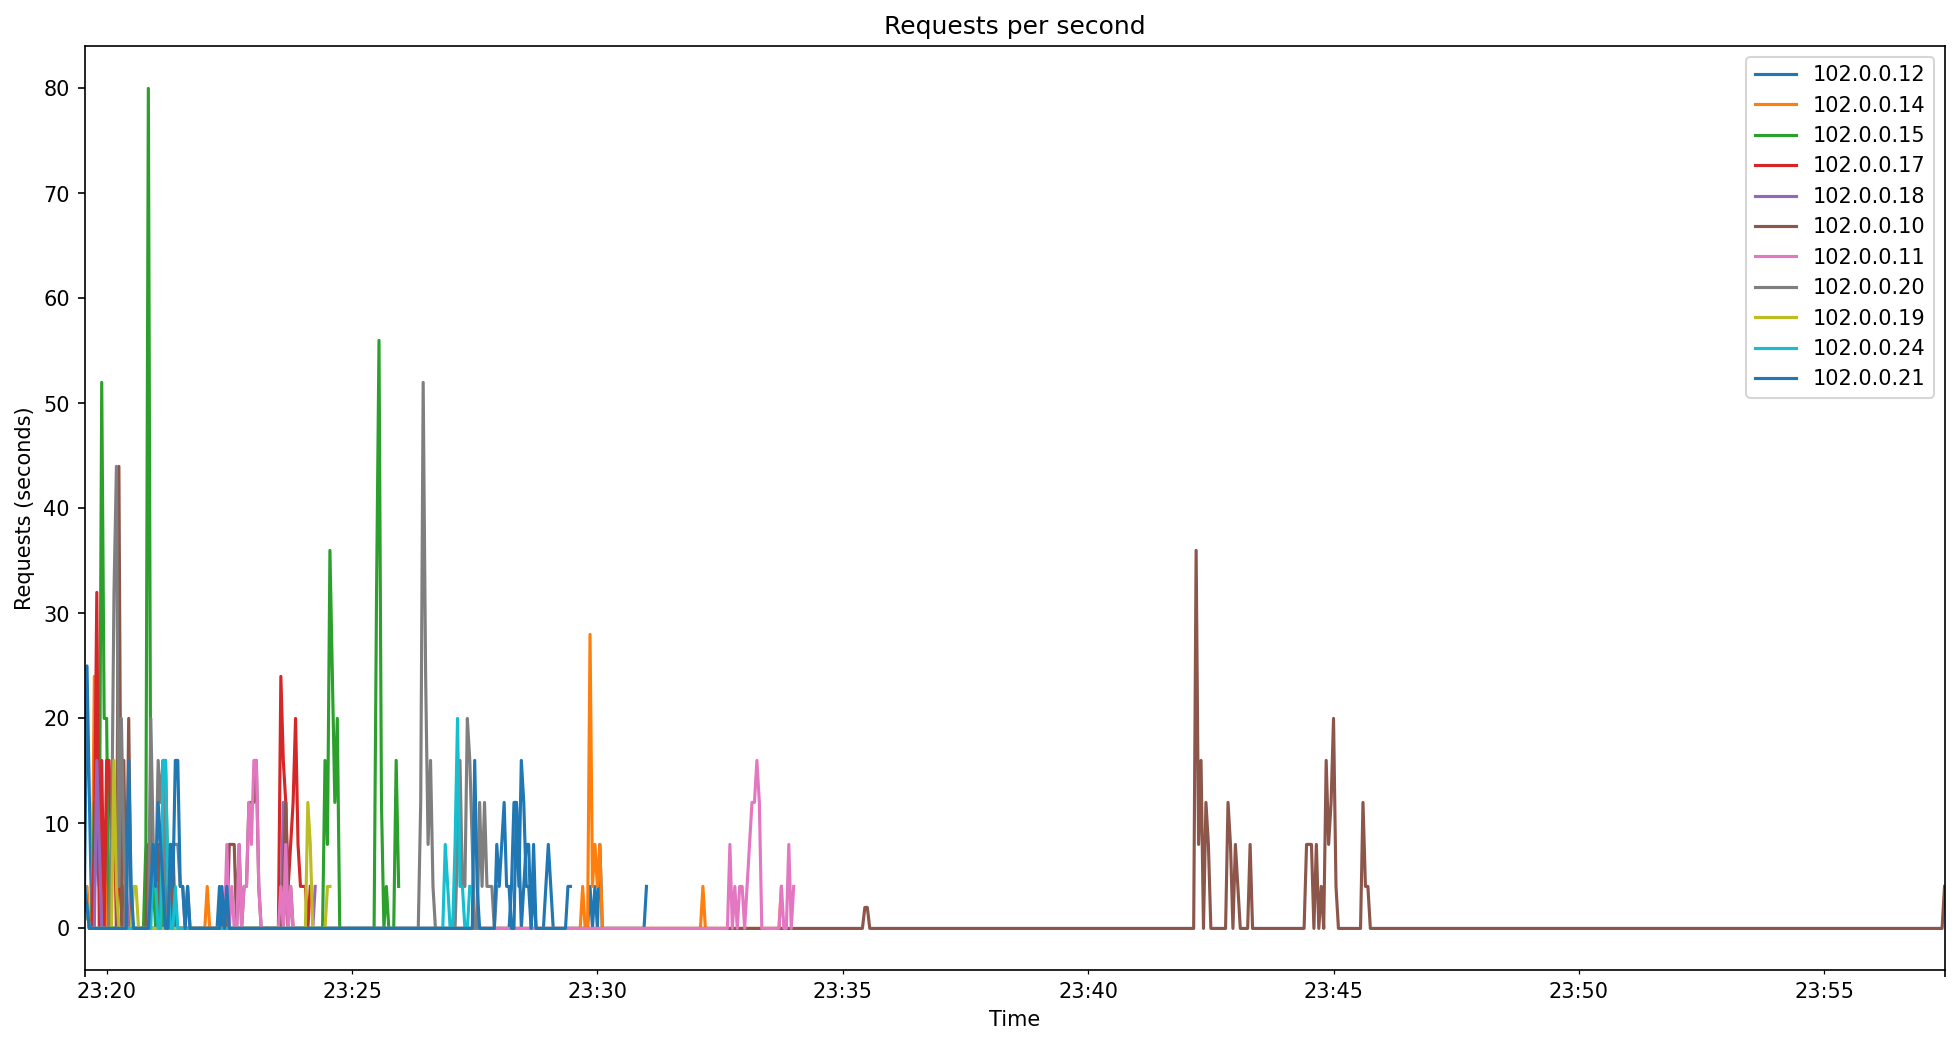

In [11]:
## Viz
# importing Libraries
  
# import pandas as pd
import pandas as pd
  
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
  
# code
# Visualizing The Open Price of all the stocks
  
# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.

total = 0
for f in flows_ts_ip_total:
    if total > 10:
        break
    total += 1
    flows_ts_ip_total[f]['count'].plot(label=f)
  
plt.title('Requests per second')
  
# adding Label to the x-axis
plt.xlabel('Time')
plt.ylabel('Requests (seconds)')
  
# adding legend to the curve
plt.legend()

In [12]:
import numpy as np
import math
from sklearn import metrics
from statistics import mean
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_completeness_v_measure

def ip_to_group(ip):
    if ip.split(".")[0] != '102':
        return -1
    return math.floor((int(ip.split(".")[-1])-2) / 5)

def get_real_label(dic):
    data = dic.keys()
    result = np.array([ip_to_group(xi) for xi in data])
    return result

# compute cluster purity
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

def weighted_purity(true_labels, found_labels):
    s = 0
    total = 0
    for c in true_labels.unique():
        selection = df[df['cluster'] == c]
        p = purity_score(selection['real_label'], selection['cluster'])
        total += len(selection)
        s += p * len(selection)
    return s/total

answers = get_real_label(flows_ts_ip_total)

In [13]:
def gpt_cluster_metrics(true_labels, found_labels):

    # Calculate the Adjusted Rand Index
    ari = adjusted_rand_score(true_labels, found_labels)
    ari_range = (-1, 1)
    ari_ideal = 1

    # Calculate the Normalized Mutual Information
    nmi = normalized_mutual_info_score(true_labels, found_labels)
    nmi_range = (0, 1)
    nmi_ideal = 1

    # Calculate the Fowlkes-Mallows Index
    fmi = fowlkes_mallows_score(true_labels, found_labels)
    fmi_range = (0, 1)
    fmi_ideal = 1

    # Calculate homogeneity, completeness, and V-measure
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, found_labels)
    hcv_range = (0, 1)
    hcv_ideal = 1

    # Print the results
    print(f"Adjusted Rand Index: {ari:.4f} [range: {ari_range}, ideal: {ari_ideal}]")
    print(f"Normalized Mutual Information: {nmi:.4f} [range: {nmi_range}, ideal: {nmi_ideal}]")
    print(f"Fowlkes-Mallows Index: {fmi:.4f} [range: {fmi_range}, ideal: {fmi_ideal}]")
    print(f"Homogeneity: {homogeneity:.4f} [range: {hcv_range}, ideal: {hcv_ideal}]")
    print(f"Completeness: {completeness:.4f} [range: {hcv_range}, ideal: {hcv_ideal}]")
    print(f"V-measure: {v_measure:.4f} [range: {hcv_range}, ideal: {hcv_ideal}]")

In [14]:
from fastdtw import fastdtw

def my_dtw(ts1, ts2):
    distance, path = fastdtw(ts1, ts2)
    return distance


def my_dist(ts1, ts2, ip1="", ip2=""):
    return my_pl_ts(ts1, ts2, ip1, ip2)


from ripser import ripser
from sklearn import preprocessing


def rip_ts(window, dim, skip, data):
    for_pl = {}
    for i in range(0, len(data)-window+1, skip):
        diagrams = ripser(data[i:i+window])['dgms']
        for_pl[i] = diagrams[dim]
    return for_pl


import rpls_py


def ts_to_tda(data, header, dim=0, window=3, skip=1, k=2, debug=False):
    data = data.astype(float)

    # compute birth death pairs
    rip_data = rip_ts(window, dim, skip, data)
    new_ts = [None] * len(rip_data)
    for i, pairs in rip_data.items():
        pairs = [(x[0], x[1]) for x in pairs]
        new_ts[i] = rpls_py.pairs_to_l2_norm(pairs, k, debug)
    return new_ts


def my_pl_ts(ts1, ts2, ip1, ip2):
    return my_dtw(ts1, ts2)


from scipy.spatial.distance import pdist


def calc_dist_matrix(samples, my_dist, multi_to_single=lambda x: x):
    # create a list of dataframe values
    X = [multi_to_single(df.to_numpy(), ip) for ip, df in samples.items()]
    n_samples = len(X)
    dist_mat = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            d = my_dist(X[i], X[j], i, j)
            dist_mat[i, j] = d
            dist_mat[j, i] = d
    return squareform(dist_mat)


def cast_col(col: pd.Series) -> pd.Series:
    if col.dtype == 'object':
        if all([is_float(x) for x in col]):
            return col.astype(float)
        elif all([is_int(x) for x in col]):
            return col.astype(float)
        elif all([is_date(x) for x in col]):
            return pd.Series(pd.to_datetime(col)).astype(float)
        else:
            return col.astype(str)
    elif np.issubdtype(col.dtype, np.datetime64):
        return col.astype(np.int64)
    else:
        return col.astype(float)


def is_float(s: str) -> bool:
    try:
        float(s)
        return True
    except ValueError:
        return False


def is_int(s: str) -> bool:
    try:
        int(s)
        return True
    except ValueError:
        return False


def is_date(s: str) -> bool:
    try:
        pd.to_datetime(s)
        return True
    except ValueError:
        return False


def cast_columns(df):
    for col in df.columns:
        df[col] = cast_col(df[col])
    return df

In [15]:
def get_chat_logs(scope):
    df = scope.as_df()
    df["text_len"] = df["text"].apply(len)
    users = df["username"].unique()
    client_log = {}
    for user in users:
        client_log[user] = df_to_ts(df[df["username"] == user], time_col='time').set_index('time')
    return client_log

client_chat_logs = get_chat_logs(chatlog)

/tmp/ipykernel_354662/2025178768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = 1
/tmp/ipykernel_354662/2025178768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = 1
/tmp/ipykernel_354662/2025178768.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [18]:
client_chat_logs['/tordata/config/group_0_user_4']

,text_len,count
time,,
2023-04-30 23:21:51,283,1
2023-04-30 23:21:54,0,0
2023-04-30 23:21:57,0,0
2023-04-30 23:22:00,929,2
2023-04-30 23:22:03,1356,5
...,...,...
2023-04-30 23:35:48,0,0
2023-04-30 23:35:51,0,0
2023-04-30 23:35:54,0,0


In [21]:
def ip_to_user(ip, group_size=5, starting=10):
    local_net = int(ip.split(".")[-1]) - starting
    user = local_net%group_size
    group = math.floor(local_net/group_size)
    return '/tordata/config/group_' + str(group) + "_user_" + str(user)

ip_to_user('102.0.0.73')

'/tordata/config/group_12_user_3'

In [22]:
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)

def compare_ts(ts1, ts2):
    # dtw_classic, path_classic = dtw(ts1, ts2, dist='square',
    #                             method='classic', return_path=True)
    # return dtw_classic
    return my_dtw(ts1, ts2)

def normalize_ts(ts):
    ts=(ts-ts.min())/(ts.max()-ts.min())
    return ts.fillna(0)

def compare_ts_reshape(ts1, ts2):
    ts1_norm = ts1.copy(deep=True)
    ts2_norm = ts2.copy(deep=True)
    
    buffer_room = 10 # in seconds
    delay = 2
    
    # lock to same range with buffer room on each side to account for network (or PPT) delay
    start = min(ts1.index.values) + (delay * 1000000000) - (buffer_room * 1000000000)
    end = max(ts1.index.values) + (buffer_room * 1000000000)+ (delay * 1000000000)
#     print("start: " + str(start))
#     print("end: " + str(end))
    #print(end - start)
    
#     ts1_norm = ts1_norm[start:end]
    ts2_norm = ts2_norm[start:end]
   # print(len(ts2_norm))
    
    # detect if no overlap
    if len(ts1_norm) < 2 or len(ts2_norm) < 2:
        return float("inf")
    
    # Normalize peaks?
    ts1_norm = normalize_ts(ts1_norm)
    ts2_norm = normalize_ts(ts2_norm)
    
    plot_ts(ts1_norm, ts2_norm)
    exit(1)

    return compare_ts(ts1_norm, ts2_norm)

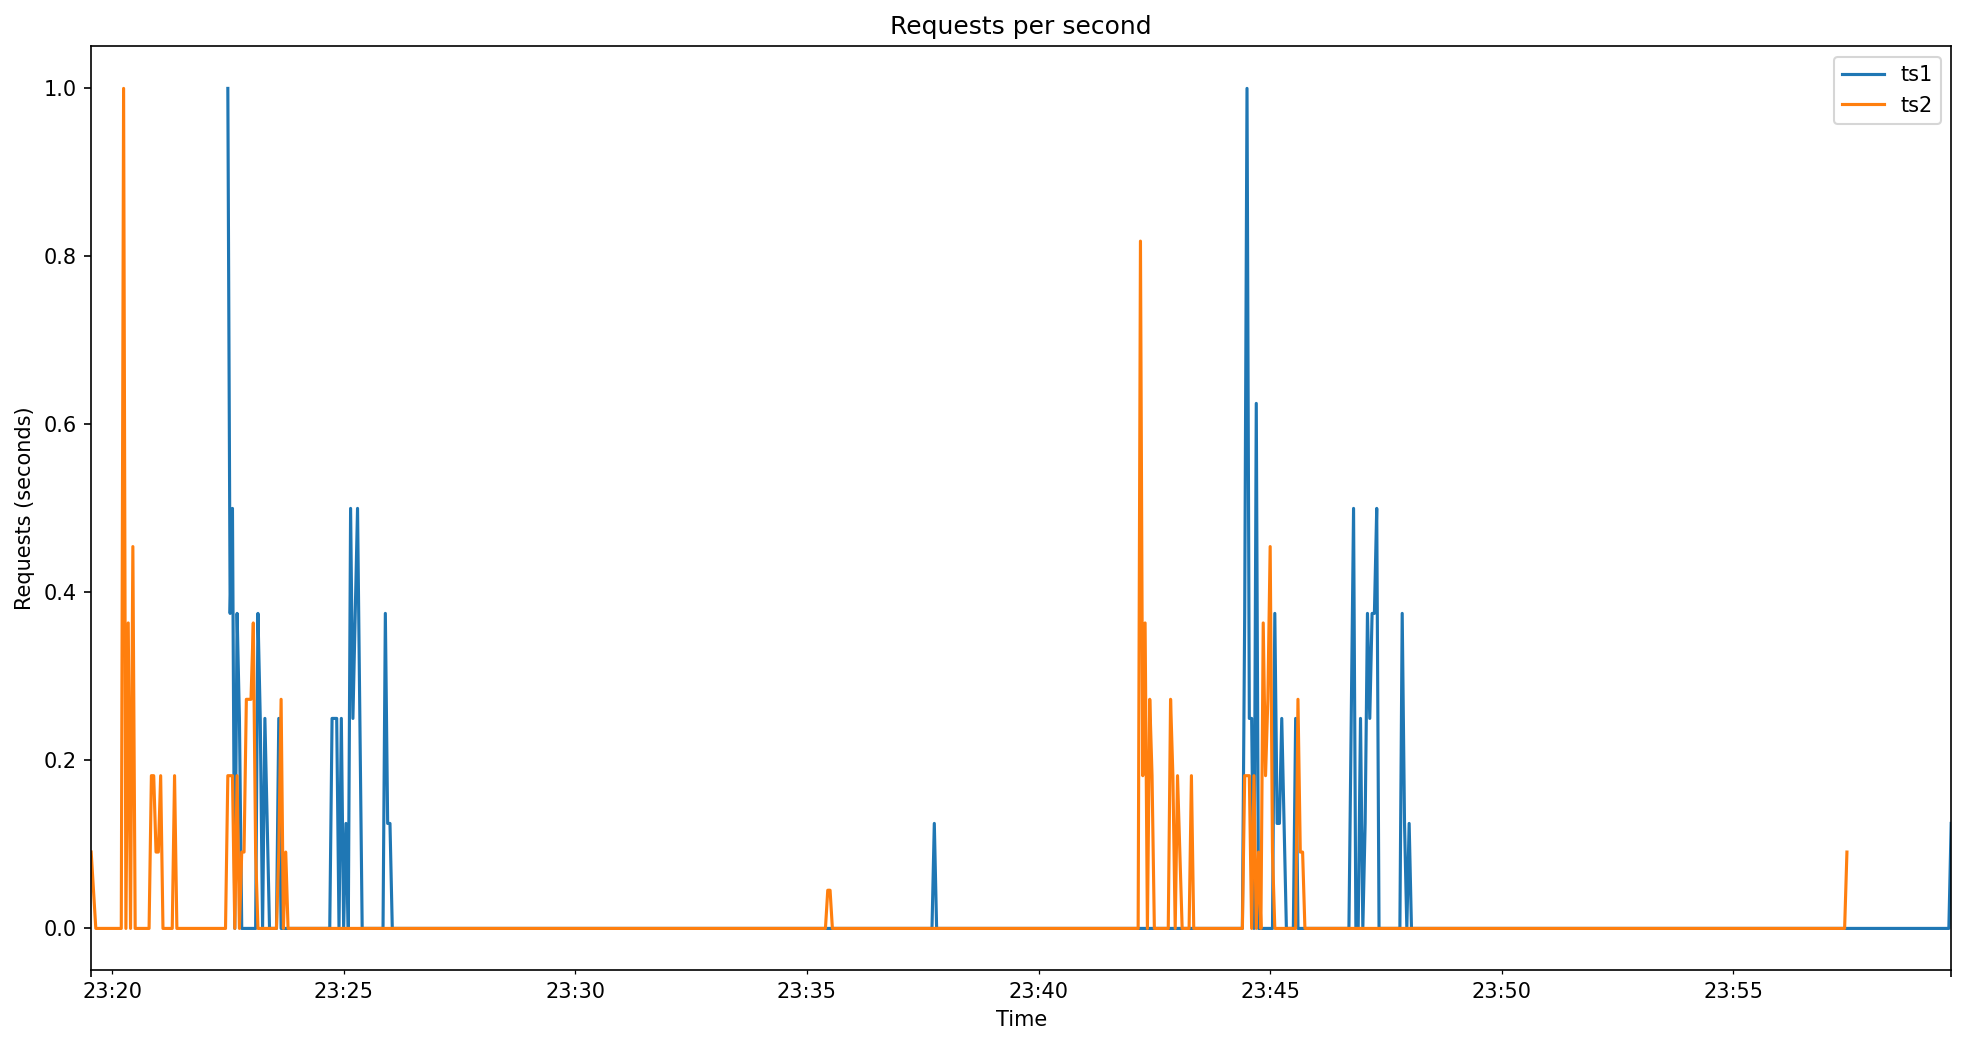

In [23]:
def plot_ts(ts1, ts2):
    # to set the plot size
    plt.figure(figsize=(16, 8), dpi=150)

    normalize_ts(ts1['count']).plot(label='ts1')
    normalize_ts(ts2['count']).plot(label='ts2')

    plt.title('Requests per second')

    # adding Label to the x-axis
    plt.xlabel('Time')
    plt.ylabel('Requests (seconds)')

    # adding legend to the curve
    plt.legend()
plot_ts(client_chat_logs['/tordata/config/group_0_user_0'], flows_ts_ip_total['102.0.0.10'])

In [ ]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import squareform


# def cluster(samples, max_clust, display=False, multi_to_single=lambda x: x):
#     dist_mat = calc_dist_matrix(samples,
#                                 my_dist,
#                                 multi_to_single=multi_to_single)

#     # Perform hierarchical clustering using the computed distances
#     Z = linkage(dist_mat, method='single')

#     # Plot a dendrogram to visualize the clustering
#     if display:
#         dendrogram(Z)

#     # Extract the cluster assignments using the threshold
#     labels = fcluster(Z, max_clust, criterion='maxclust')
# #     print(labels)

#     return labels


def evaluate(src_df_dict, dst_df_dict, features, display=False):
    src_data = {key: df.loc[:, features] for key, df in src_df_dict.items()}
    for ip in src_data:
        src_data[ip] = src_data[ip][list(features)]
    num_correct = 0
    for user in dst_df_dict:
        best = None
        best_ip = None
        for ip in src_df_dict:
            score = compare_ts_reshape(dst_df_dict[user], src_data[ip])
            return
            if best == None or score < best:
                best = score
                best_ip = ip
        # print(str(user) + "\t" + str(best_ip) + "\t" + str(best))
        if user == ip_to_user(best_ip):
            num_correct += 1
    return float(num_correct)/len(dst_df_dict)

# Find best features
import itertools
from tqdm import tqdm
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor
import os


def findsubsets(s, n):
    return list(itertools.combinations(s, n))


def evaluate_subset(src_df, dst_df, subset):
    score = evaluate(src_df, dst_df, subset)
    return score, subset


def iterate_features(src_df, dst_df, n, filename):
    features = src_df[next(iter(src_df))].columns
    subsets = findsubsets(features, n)
    results = []
    num_cpus = os.cpu_count()
    print("Using " + str(num_cpus) + " cpus for " + str(len(subsets)) + " subsets")
    with mp.Pool(processes=num_cpus) as pool:
        results = []
        for subset in subsets:
            results.append(pool.apply_async(evaluate_subset, args=(src_df, dst_df, subset)))
        with open(filename, 'a') as f:
            for result in tqdm(results, total=len(subsets)):
                score, subset = result.get()
                f.write(str(score) + "\t" + str(subset) + "\n")


flows_ts_ip_total_str_int = {}
for ip in flows_ts_ip_total:
    flows_ts_ip_total_str_int[ip] = cast_columns(flows_ts_ip_total[ip])
    
chat_log = {}
for user in client_chat_logs:
    chat_log[user] = cast_columns(client_chat_logs[user])

src_df = flows_ts_ip_total_str_int
dst_df = chat_log

dst_df_count = {}
for user in dst_df:
    dst_df_count[user] = dst_df[user][['count']]
    
purity = evaluate(src_df, dst_df_count, ['count'], display=True)
print("Accuracy: " + str(purity*100) + "%")

In [23]:
for n in range(2,3):
    break
    best_features = iterate_features(src_df, dst_df, n,
                                     "chatlog_dtw_dns_all_" + str(n) +
                                     "_" + str(datetime.now()) + ".output")